# Calibration Sorgho Mali
Ce notebook a pour objectif de réaliser une preuve de concept de calibration semi-automatique du modèle SARRA.

Il est basé sur les données du projet AgrECO Mali fournies par Michel VAKSMANN.

# Imports

In [153]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import yaml
import io
from datetime import datetime as dt
from sklearn.metrics import r2_score, mean_squared_error

sys.path.append("../../src/")
from sarra_py import *

# Chargement des données observées

In [167]:
# chargement des données
observations_full = pd.read_csv("/mnt/g/Mon Drive/CIRAD/AgrEco sorgho/observations.csv",sep=";", decimal=",")
# on retire farako qui est du maïs
#observations_full = observations_full[observations_full["NOMVAR"]=="CS20-14"].reset_index(drop=True)
#observations_full = observations_full[observations_full["NOMVAR"]=="TdC"].reset_index(drop=True)
observations_full = observations_full[observations_full["NOMVAR"]!="Farako"].reset_index(drop=True)
observations_full["DATE_SEM"] = observations_full.apply(lambda x: datetime.datetime.strptime(x["DATE_SEM"], "%d/%m/%Y").date(), axis=1)
observations_full["DATE_HARVEST"] = observations_full.apply(lambda x: datetime.datetime.strptime(x["DATE_HARVEST"], "%d/%m/%Y").date(), axis=1)
observations_full["DATE"] = observations_full.apply(lambda x: datetime.datetime.strptime(x["DATE"], "%d/%m/%Y").date(), axis=1)
observations_full["DAS"] = observations_full.apply(lambda x: (x["DATE"] - x["DATE_SEM"]).days, axis=1)
observations_full["SEMxNUMVAR"] = observations_full.apply(lambda x: str(x["SEM"])+"_"+str(x["NUMVAR"]), axis=1)

In [156]:
observations_full

,SEM,DATE_SEM,DATE_HARVEST,NUMVAR,NOMVAR,BLOC,DATE,NbBM/m²,NbTal/m²,Tig/m²,...,FEUbm/m²,FEUTal/m²,PANbm/m²,PANTal/m²,LIG,NbETN,biomasseFeuilles,biomasseAerienne,DAS,SEMxNUMVAR
0,1,2021-06-21,2021-11-05,1,CS20-14,1,2021-10-12,"5,333333333","1,066666667","6,4",...,"211,1382382","7,512121625","65,65623284",0,36,"24,75","218,6503598","956,973859",113,1_1
1,1,2021-06-21,2021-11-05,1,CS20-14,1,2021-07-27,"5,333333333",0,"5,333333333",...,"42,24409394",0,0,0,"12,25","7,75","42,24409394","67,74295245",36,1_1
2,1,2021-06-21,2021-11-05,1,CS20-14,1,2021-08-20,"5,333333333",0,"5,333333333",...,"140,1118206",0,0,0,"20,75","15,25","140,1118206","270,2023229",60,1_1
3,1,2021-06-21,2021-11-05,1,CS20-14,1,2021-11-11,"5,333333333","1,066666667","6,4",...,"70,63703704","12,8671161","12,84974093","89,74482158",36,"21,75","83,50415314","779,2401016",143,1_1
4,1,2021-06-21,2021-11-05,1,CS20-14,2,2021-10-12,"5,333333333","3,2","8,533333333",...,"189,5303409","51,81516678","29,79901153",0,34,"24,75","241,3455076","899,4619529",113,1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2,2021-07-17,2021-11-15,3,TdC,3,2021-11-11,"5,333333333",0,"5,333333333",...,"159,5115789",0,"192,6059259",0,22,15,"159,5115789","1056,746339",117,2_3
84,2,2021-07-17,2021-11-15,3,TdC,4,2021-09-16,"5,333333333",0,"5,333333333",...,"104,9034037",0,0,0,"14,25",12,"104,9034037","199,6042845",61,2_3
85,2,2021-07-17,2021-11-15,3,TdC,4,2021-08-17,"5,333333333",0,"5,333333333",...,"10,32361981",0,0,0,"7,75","3,75","10,32361981","14,9394632",31,2_3
86,2,2021-07-17,2021-11-15,3,TdC,4,2021-10-26,"5,333333333",0,"5,333333333",...,"172,3309684",0,"226,4915215",0,"22,75","15,75","172,3309684","908,0377723",101,2_3


# Chargement des données météo observées

In [157]:
# on charge les données météo observées
df_weather = pd.read_csv("/mnt/g/Mon Drive/CIRAD/AgrEco sorgho/meteo.csv",sep=";",decimal=",")

# essai mené à Sotuba
# Latitude : 12°39’N
# Longitude : 7°56’O
# en décimal : 12.653403, -7.927809
# Altitude : 320 m
latitude = 12.653403
altitude = 320

angstA = 0.29
angstB = 0.49

df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Date"], "%d/%m/%Y").date(), axis=1)
df_weather.rename(columns={"TM":"TEMP", "PR":"RAIN", 'RG MJ/m²/j':'IRRAD'}, inplace=True)
# https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
# e = RH/100 * es
df_weather["es"] = 6.11 * 10 ** ((7.5 * df_weather["TEMP"])/(237.3 + df_weather["TEMP"]))
df_weather["VAP"] = df_weather["UM"]/100 * df_weather["es"]
df_weather["ET0"] = df_weather.apply(lambda x: reference_ET(x["Jour"], latitude, altitude, x["TN"], x["TX"], x["IRRAD"]*1E6, x["VAP"], x["VT"], angstA, angstB, ETMODEL="PM")[2],axis=1)

# culture pluviale, irrigation nulle
df_weather["irrigation"]=0

In [158]:
df_weather

,Date,TN,TX,TEMP,UN,UX,UM,RAIN,Day,Month,...,VT,Hmax,IGA,RG J/cm²/j,IRRAD,Jour,es,VAP,ET0,irrigation
0,01/01/2021,15.0,37.0,26.00,24,78,51.0,0.0,1,1,...,0.4,11.27,2953,2253,22.53,2021-01-01,33.623374,17.147921,3.979921,0
1,02/01/2021,19.5,36.5,28.00,25,45,35.0,0.0,2,1,...,1.0,11.27,2957,2256,22.56,2021-01-02,37.809239,13.233234,4.782193,0
2,03/01/2021,17.5,36.3,26.90,23,52,37.5,0.0,3,1,...,0.6,11.28,2961,2216,22.16,2021-01-03,35.454164,13.295312,4.108260,0
3,04/01/2021,20.5,37.0,28.75,19,42,30.5,0.0,4,1,...,0.8,11.28,2966,2261,22.61,2021-01-04,39.492004,12.045061,4.510258,0
4,05/01/2021,19.7,35.5,27.60,14,35,24.5,0.0,5,1,...,1.4,11.29,2971,2291,22.91,2021-01-05,36.937557,9.049701,5.347123,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27/12/2021,20.8,32.8,26.80,17,26,21.5,0.0,27,12,...,1.4,11.26,2937,1455,14.55,2021-12-27,35.246546,7.578007,4.527204,0
361,28/12/2021,19.7,33.4,26.55,12,37,24.5,0.0,28,12,...,1.6,11.26,2940,2203,22.03,2021-12-28,34.732127,8.509371,5.364298,0
362,29/12/2021,13.7,33.5,23.60,17,64,40.5,0.0,29,12,...,1.2,11.26,2942,2245,22.45,2021-12-29,29.138156,11.800953,4.662442,0
363,30/12/2021,13.2,35.0,24.10,16,70,43.0,0.0,30,12,...,0.8,11.27,2945,2247,22.47,2021-12-30,30.026881,12.911559,4.265237,0


# Preparation du run

## Loading parameters

In [159]:
# le nombre d'échantillons correspond au nombre de répétitions indépendantes de l'expérimentation
# ici, pour une même variété, deux semis séparés ont été réalisés
num_samples = len(observations_full["SEMxNUMVAR"].unique())

# on définit les dimensions de la matrice de simulation
grid_width = 1 # largeur de 1
grid_height = num_samples # on répartit les différents runs parallèles sur la colonne
duration = 180 # 6 mois de durée de simulation seront suffisants pour le sorgho

# date de démarrage de la simulation = date la plus précoce moins 15 jours
lag = 15
date_start = observations_full["DATE_SEM"].values.min() - datetime.timedelta(days=lag)

In [142]:
# YAML parameter filenames
file_paramVariete = "sorgho_variety.yaml"
file_paramITK = "sorgho_itk.yaml" # do not forget to override date_start
file_paramTypeSol = "sorgho_soil.yaml"

# Read YAML files
# paramVariete
with open(os.path.join('../../data/params/variety/',file_paramVariete), 'r') as stream:
    paramVariete = yaml.safe_load(stream)    
if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()

# paramITK
with open(os.path.join('../../data/params/itk/',file_paramITK), 'r') as stream:
    paramITK = yaml.safe_load(stream)
# overriding sowing dates with the sowing dates of each of the samples
# we must take care of the order of the dates
paramITK["DateSemis"] = [observations_full.loc[observations_full["SEMxNUMVAR"] == observations_full["SEMxNUMVAR"].unique()[sem], "DATE_SEM"].max() for sem in range(len(observations_full["SEMxNUMVAR"].unique()))]

# paramTypeSol
with open(os.path.join('../../data/params/soil/',file_paramTypeSol), 'r') as stream:
    paramTypeSol = yaml.safe_load(stream)
if ~np.isnan(paramITK["NI"]):
    print("NI NON NULL") 
    paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)

In [143]:
# building weather dfs
# one df per sample ; here there are the same because experiments were done on the same site
df_weather_collection = {}
for sample in tqdm(range(num_samples)):
    df_weather_collection[sample] = df_weather[(df_weather["Jour"]>=date_start) & (df_weather["Jour"]<date_start+datetime.timedelta(days=duration))].reset_index(drop=True)

100%|██████████| 6/6 [00:00<00:00, 1036.57it/s]


## Building matrices

In [144]:
def InitSup2_alt(data, grid_width, grid_height, duration, df_weather_collection):
    data["tpMoy"] = np.concatenate([df_weather_collection[df_weather_id]["TEMP"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["rain"] = np.concatenate([df_weather_collection[df_weather_id]["RAIN"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["ET0"] = np.concatenate([df_weather_collection[df_weather_id]["ET0"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["rg"] = np.concatenate([df_weather_collection[df_weather_id]["IRRAD"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    data["irrigation"] = np.concatenate([df_weather_collection[df_weather_id]["irrigation"].values for df_weather_id in df_weather_collection]).reshape(grid_width, grid_height, duration)
    return data

In [145]:
def InitSoilReservoirs(data, grid_width, grid_height, duration):
    for param in ["ru", "epaisseurSurf", "stockIniProf", "epaisseurProf", "seuilRuiss", "pourcRuiss"] :
        data[param] = np.full((grid_width, grid_height, duration), (paramTypeSol[param]))
    return data

In [146]:
data_run = {}

# on initialise 
data_run = InitSoilReservoirs(data_run, grid_width, grid_height, duration)
data_run = InitPlotMc(data_run, grid_width, grid_height, paramITK, paramTypeSol, duration)
data_run = InitiationCulture(data_run, grid_width, grid_height, duration, paramVariete)
data_run = InitSup(data_run, grid_width, grid_height, duration, paramTypeSol, paramITK) # penser à override l'irrigation
data_run = InitSup2_alt(data_run, grid_width, grid_height, duration, df_weather_collection)
data_run = EvalPar(data_run)

# Run

In [147]:
import warnings
warnings.filterwarnings("ignore")

for j in tqdm(range(duration)):
    #procédure pour prendre en compte une date de semis différente par sample/pixel vertical
    data_run_local = EvalPhenoSarrahV3(j, data_run, paramITK, paramVariete).copy() # ***phenologie*** et exmodules ### trad OK
    data_run_local = EvalDegresJourSarrahV3(j, data_run_local, paramVariete) # ***phenologie*** et exmodules ### trad OK
    for sample in range(num_samples):
        if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"][sample]:
            for variable in data_run_local :
                try:
                    data_run[variable][:,sample,j:] = data_run_local[variable][0,sample,j:].copy()
                    data_run[variable][:,sample,j:] = data_run_local[variable][:,sample,j:].copy()
                except:
                    pass
    #bilan hydrique
    data_run = EvalIrrigPhase(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data_run = PluieIrrig(j, data_run) # ***bileau***, exmodules 2 ###trad OK
    data_run = RempliMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data_run = EvalRunOff(j, data_run, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data_run = EvolRurCstr2(j, data_run, paramITK) # ***bileau*** ##trad OK
    data_run = rempliRes(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data_run = EvalFESW(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data_run = EvalKceMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data_run = DemandeSol(j, data_run) # ***bileau***, exmodules 1 & 2 ### trad OK
    data_run = EvapMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data_run = EvapRuSurf(j, data_run) # ***bileau***, exmodules 1 & 2 ###trad OK
    data_run = EvalFTSW(j, data_run) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data_run = EvolKcpKcIni(j, data_run, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data_run = DemandePlante(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data_run = EvalKcTot(j, data_run) # ***bileau***, exmodules 1 & 2 ## trad O
    data_run = CstrPFactor(j, data_run, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data_run = EvalTranspi(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data_run = ConsoResSep(j, data_run) # ***bileau***; exmodules 1 & 2 # trad O
    
    # phenologie
    data_run = EvalVitesseRacSarraV3(j, data_run, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data_run = EvalLtr(j, data_run, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data_run = EvalConversion(j, data_run, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data_run = BiomDensOptSarV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data_run = EvalAssimSarrahV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data_run = EvalRespMaintSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data_run = EvolBiomTotSarrahV4(j, data_run, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data_run = EvalRdtPotRespSarV42(j, data_run, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data_run = EvolBiomAeroSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data_run = EvalReallocationSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data_run = EvalBiomasseRacinaire(j, data_run) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data_run = EvalFeuilleTigeSarrahV4(j, data_run, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data_run = EvalBiomasseVegetati(j, data_run) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data_run = EvalSlaSarrahV3(j, data_run, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data_run = EvolLAIPhases(j, data_run) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data_run = EvolDayRdtSarraV3(j, data_run) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    
    #phenologie
    data_run = PhotoperSarrahV3(j, data_run, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data_run = MortaliteSarraV3(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data_run = BiomDensiteSarraV42(j, data_run, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data_run = BiomMcUBTSV3(j, data_run, paramITK) # ***bilancarbonsarra***, exmodules 2
    data_run = MAJBiomMcSV3(data_run) # ***bilancarbonsarra***, exmodules 2

100%|██████████| 180/180 [00:00<00:00, 299.38it/s]


In [148]:
    sim_harvest = np.where(data_run["numPhase"]==7)[2] - lag
    # we remove the lag as the matrix time series starts with a -15 days lag 
    obs_harvest = np.array([observations_full.loc[observations_full["SEMxNUMVAR"]==observations_full["SEMxNUMVAR"].unique()[sem], "DAS"].max() for sem in range(len(observations_full["SEMxNUMVAR"].unique()))])
    df_comparison = pd.DataFrame({"observed_harvest":obs_harvest, "sim_harvest":sim_harvest})
    rmse = mean_squared_error(df_comparison["observed_harvest"], df_comparison["sim_harvest"], squared=False)
    print("obs",obs_harvest,"sim",sim_harvest)

obs [143 143 143 125  61 117] sim [ 90  90  90 117 117 117]


# essai optim

In [132]:
import warnings
warnings.filterwarnings("ignore")

def run(SDJRPR, SDJMatu1, SDJMatu2):

    #########################################
    # YAML parameter filenames
    file_paramVariete = "sorgho_variety.yaml"
    file_paramITK = "sorgho_itk.yaml" # do not forget to override date_start
    file_paramTypeSol = "sorgho_soil.yaml"

    # Read YAML files
    # paramVariete
    with open(os.path.join('../../data/params/variety/',file_paramVariete), 'r') as stream:
        paramVariete = yaml.safe_load(stream)    
    if paramVariete["feuilAeroBase"] == 0.1 :
        raise exception()

    # paramITK
    with open(os.path.join('../../data/params/itk/',file_paramITK), 'r') as stream:
        paramITK = yaml.safe_load(stream)
    # overriding sowing dates with the sowing dates of each of the samples
    # we must take care of the order of the dates
    paramITK["DateSemis"] = [observations_full.loc[observations_full["SEM"] == observations_full["SEM"].unique()[sem], "DATE_SEM"].max() for sem in range(len(observations_full["SEM"].unique()))]

    # paramTypeSol
    with open(os.path.join('../../data/params/soil/',file_paramTypeSol), 'r') as stream:
        paramTypeSol = yaml.safe_load(stream)
    if ~np.isnan(paramITK["NI"]):
        print("NI NON NULL") 
        paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631) 


    #########################################
    # paramVariete["SDJBVP"] = SDJBVP
    paramVariete["SDJRPR"] = SDJRPR
    paramVariete["SDJMatu1"] = SDJMatu1
    paramVariete["SDJMatu2"] = SDJMatu2


    #########################################
    # building weather dfs
    # one df per sample ; here there are the same because experiments were done on the same site
    df_weather_collection = {}
    for sample in tqdm(range(num_samples)):
        df_weather_collection[sample] = df_weather[(df_weather["Jour"]>=date_start) & (df_weather["Jour"]<date_start+datetime.timedelta(days=duration))].reset_index(drop=True)


    #########################################
    data_run = {}

    # on initialise 
    data_run = InitSoilReservoirs(data_run, grid_width, grid_height, duration)
    data_run = InitPlotMc(data_run, grid_width, grid_height, paramITK, paramTypeSol, duration)
    data_run = InitiationCulture(data_run, grid_width, grid_height, duration, paramVariete)
    data_run = InitSup(data_run, grid_width, grid_height, duration, paramTypeSol, paramITK) # penser à override l'irrigation
    data_run = InitSup2_alt(data_run, grid_width, grid_height, duration, df_weather_collection)
    data_run = EvalPar(data_run)

    #########################################
    for j in tqdm(range(duration)):
        #procédure pour prendre en compte une date de semis différente par sample/pixel vertical
        data_run_local = EvalPhenoSarrahV3(j, data_run, paramITK, paramVariete).copy() # ***phenologie*** et exmodules ### trad OK
        data_run_local = EvalDegresJourSarrahV3(j, data_run_local, paramVariete) # ***phenologie*** et exmodules ### trad OK
        for sample in range(num_samples):
            if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"][sample]:
                for variable in data_run_local :
                    try:
                        data_run[variable][:,sample,j:] = data_run_local[variable][0,sample,j:].copy()
                        data_run[variable][:,sample,j:] = data_run_local[variable][:,sample,j:].copy()
                    except:
                        pass
        #bilan hydrique
        data_run = EvalIrrigPhase(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data_run = PluieIrrig(j, data_run) # ***bileau***, exmodules 2 ###trad OK
        data_run = RempliMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data_run = EvalRunOff(j, data_run, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
        data_run = EvolRurCstr2(j, data_run, paramITK) # ***bileau*** ##trad OK
        data_run = rempliRes(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
        data_run = EvalFESW(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
        data_run = EvalKceMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ###trad OK
        data_run = DemandeSol(j, data_run) # ***bileau***, exmodules 1 & 2 ### trad OK
        data_run = EvapMc(j, data_run, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data_run = EvapRuSurf(j, data_run) # ***bileau***, exmodules 1 & 2 ###trad OK
        data_run = EvalFTSW(j, data_run) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
        data_run = EvolKcpKcIni(j, data_run, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
        data_run = DemandePlante(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
        data_run = EvalKcTot(j, data_run) # ***bileau***, exmodules 1 & 2 ## trad O
        data_run = CstrPFactor(j, data_run, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
        data_run = EvalTranspi(j, data_run) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
        data_run = ConsoResSep(j, data_run) # ***bileau***; exmodules 1 & 2 # trad O
        
        # phenologie
        data_run = EvalVitesseRacSarraV3(j, data_run, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
        
        # bilan carbone
        data_run = EvalLtr(j, data_run, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
        data_run = EvalConversion(j, data_run, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
        data_run = BiomDensOptSarV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
        data_run = EvalAssimSarrahV42(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
        data_run = EvalRespMaintSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
        data_run = EvolBiomTotSarrahV4(j, data_run, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
        data_run = EvalRdtPotRespSarV42(j, data_run, paramVariete) # ***bilancarbonsarra*** ###trad OK
        data_run = EvolBiomAeroSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
        data_run = EvalReallocationSarrahV3(j, data_run, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
        data_run = EvalBiomasseRacinaire(j, data_run) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
        data_run = EvalFeuilleTigeSarrahV4(j, data_run, paramVariete) # ***bilancarbonesarra*** ### trad OK
        data_run = EvalBiomasseVegetati(j, data_run) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
        data_run = EvalSlaSarrahV3(j, data_run, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
        data_run = EvolLAIPhases(j, data_run) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
        data_run = EvolDayRdtSarraV3(j, data_run) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
        
        #phenologie
        data_run = PhotoperSarrahV3(j, data_run, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
        
        # bilan carbone
        data_run = MortaliteSarraV3(j, data_run, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
        data_run = BiomDensiteSarraV42(j, data_run, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
        data_run = BiomMcUBTSV3(j, data_run, paramITK) # ***bilancarbonsarra***, exmodules 2
        data_run = MAJBiomMcSV3(data_run) # ***bilancarbonsarra***, exmodules 2


    #########################################
    # for each experiment, we consider the harvest date is the date of last observation
    sim_harvest = np.where(data_run["numPhase"]==7)[2] - lag
    # we remove the lag as the matrix time series starts with a -15 days lag 
    obs_harvest = np.array([observations_full.loc[observations_full["SEMxNUMVAR"]==observations_full["SEMxNUMVAR"].unique()[sem], "DAS"].max() for sem in range(len(observations_full["SEMxNUMVAR"].unique()))])
    df_comparison = pd.DataFrame({"observed_harvest":obs_harvest, "sim_harvest":sim_harvest})
    rmse = mean_squared_error(df_comparison["observed_harvest"], df_comparison["sim_harvest"], squared=False)
    print("obs",obs_harvest,"sim",sim_harvest)

    import matplotlib.colors as mcolors
    mcolors.BASE_COLORS
    colors = mcolors.BASE_COLORS[0:num_samples]

    for sample in range(num_samples):
        plt.vlines(np.array([observations_full.loc[observations_full["SEMxNUMVAR"]==observations_full["SEMxNUMVAR"].unique()[sem], "DAS"].max() for sem in range(len(observations_full["SEMxNUMVAR"].unique()))])[sample],0,7, color=colors[sample])
        plt.plot(data_run["numPhase"][0,sample,:], label=str(sample), color=colors[sample])

    plt.legend()    
    plt.show()

    return -rmse

In [133]:
# def constraint_function(SDJBVP, SDJRPR, SDJMatu1, SDJMatu2):
def constraint_function(SDJBVP):
    # test des contraintes sur les sommes de temp

    # SARRA  |---Levée---|---BVP---|---PSP---|---RPR---|---MATU1---|---MATU2---|
    # WOFOST |---TSUMEM--|------------TSUM1------------|---------TSUM2---------|
    
    # WOFOST TSUM1
    # temperature sum from emergence to anthesis
    # rice_eu : 875
    # rice_irri : 800
    # rice_501 : 875
    # rice_HYV_IR8 : 800
    # Rice_IR64616H_DS : 1420
    # Rice_IR64616H_WS : 1500
    # Rice_IR64 : 1570
    # rice_IR72 : 1420
    # Rice_IR72_DS : 1420
    # Rice_IR72_WS : 1550
    # Rice_IR8A : 1633

    # WOFOST TSUM2
    # temperature sum from anthesis to maturity
    # rice_eu : 625
    # rice_irri : 465
    # rice_501 : 625
    # rice_HYV_IR8 : 465
    # Rice_IR64616H_DS : 680
    # Rice_IR64616H_WS : 580
    # Rice_IR64 : 770
    # rice_IR72 : 630
    # Rice_IR72_DS : 630
    # Rice_IR72_WS : 600
    # Rice_IR8A : 506
    
    if (SDJBVP + SDJRPR < 800) or (SDJBVP + SDJRPR > 1633):
        return 0
    if (SDJMatu1 + SDJMatu2 < 465) or (SDJMatu1 + SDJMatu2 > 770):
        return 0
    else:
        return 1

In [134]:
from bayes_opt import BayesianOptimization
from scipy.optimize import NonlinearConstraint

# SDJBVP: 400.0 # proposition : 800/2
# SDJRPR: 400.0 # proposition : 800/2
# SDJMatu1: 325.0 # proposition : 650/2
# SDJMatu2: 325.0 # proposition : 650/2

# Bounded region of parameter space
research_space_width = 100

pbounds = {
    #'SDJBVP': (200, 600),
    'SDJRPR': (500-research_space_width, 500+research_space_width),
    'SDJMatu1': (360-research_space_width, 360+research_space_width),
    'SDJMatu2': (170-research_space_width, 170+research_space_width)
    }
    
#constraint = NonlinearConstraint(constraint_function, -np.inf, 0.5)

optimizer = BayesianOptimization(
    f=run,
    pbounds=pbounds,
    # constraint=constraint,
    random_state=1,
)

In [135]:
optimizer.maximize(init_points=20, n_iter=60)

|   iter    |  target   | SDJMatu1  | SDJMatu2  |  SDJRPR   |
-------------------------------------------------------------


  0%|          | 0/180 [00:00<?, ?it/s]


IndexError: list index out of range

In [98]:
optimizer.max

{'target': -25.553864678361276,
 'params': {'SDJMatu1': 460.0, 'SDJMatu2': 270.0, 'SDJRPR': 600.0}}

In [150]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [151]:
interact(run, SDJRPR=500, SDJMatu1=360, SDJMatu2=170)

interactive(children=(IntSlider(value=500, description='SDJRPR', max=1500, min=-500), IntSlider(value=360, des…

<function __main__.run(SDJRPR, SDJMatu1, SDJMatu2)>

# test pykrige biomasse

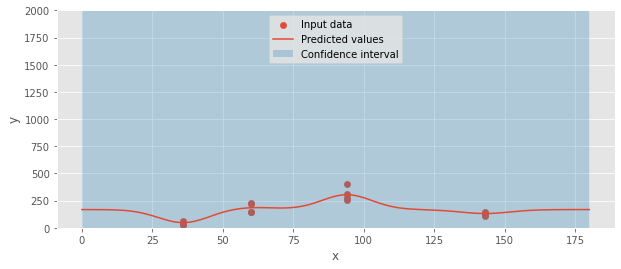

In [182]:
import matplotlib.pyplot as plt
import numpy as np

from pykrige import OrdinaryKriging

plt.style.use("ggplot")

# fmt: off
# Data taken from
# https://blog.dominodatalab.com/fitting-gaussian-process-models-python/
X, y = np.array(observations_full.loc[(observations_full["NOMVAR"]=="TdC") & (observations_full["SEM"]==1), ["DAS","biomasseFeuilles"]]).T
# fmt: on


X_pred = np.linspace(0, 180, 180)

# pykrige doesn't support 1D data for now, only 2D or 3D
# adapting the 1D input to 2D
uk = OrdinaryKriging(X, np.zeros(X.shape), y, variogram_model="gaussian")

y_pred, y_std = uk.execute("grid", X_pred, np.array([0.0]))

y_pred = np.squeeze(y_pred)
y_std = np.squeeze(y_std)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.scatter(X, y, s=40, label="Input data")


ax.plot(X_pred, y_pred, label="Predicted values")
ax.fill_between(
    X_pred,
    y_pred - 3 * y_std,
    y_pred + 3 * y_std,
    alpha=0.3,
    label="Confidence interval",
)
ax.legend(loc=9)
ax.set_xlabel("x")
ax.set_ylabel("y")
#ax.set_xlim(-6, 6)
ax.set_ylim(0, 2000)
plt.show()